Centroid of the detected ball: (X, Y) = (260, 427)


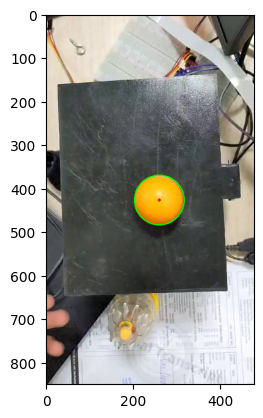

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
frame = cv2.imread('frames/frame_16.jpg')
# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# Apply Gaussian blur
gray_blurred = cv2.GaussianBlur(gray, (9, 9), 0)
# Apply Hough Circle Transform
circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1.2, 100, param1=100, param2=40, minRadius=35, maxRadius=100)

# Ensure at least some circles were found
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)

        # Draw the center of the circle
        cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)
        
        # Print the centroid coordinates
        print("Centroid of the detected ball: (X, Y) = ({}, {})".format(i[0], i[1]))
# Show the result
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
def initialize_kalman():
    ''' Initialize and return a Kalman Filter for tracking a ball in 2D space. '''
    kf = cv2.KalmanFilter(4, 2)  # 4 state parameters, 2 measurement parameters
    kf.transitionMatrix = np.array([[1, 0, 1, 0], 
                                    [0, 1, 0, 1], 
                                    [0, 0, 1, 0], 
                                    [0, 0, 0, 1]], np.float32)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], 
                                     [0, 1, 0, 0]], np.float32)
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.1
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1
    kf.errorCovPost = np.eye(4, dtype=np.float32)
    kf.statePost = np.random.randn(4, 1).astype(np.float32)  # Random initial state

    return kf

In [3]:
def getCentroid(frame, kf, dp=1.2, dist=100, param1=100, param2=50, minRadius=35, maxRadius=60, kernel_size=9):
    '''
    Function to detect the centroid of a ball in a frame using Hough Circle Transform
    frame: The frame in which the ball is to be detected
    dp: Inverse ratio of the accumulator resolution to the image resolution
    dist: Minimum distance between the centers of the detected circles
    param1: Sensitivity of the edge detection in the Canny edge detector
    param2: Number of points that must be in a circle to be considered a circle
    minRadius: Minimum circle radius
    maxRadius: Maximum circle radius
    return: The frame with the detected circle and the centroid coordinates
    '''
    assert kernel_size % 2 == 1, "Kernel size must be an odd number"

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp, dist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

    # Prediction step of the Kalman Filter
    predicted = kf.predict()

    # # Ensure at least some circles were found
    # centroid = (0, 0)
    # if circles is not None:
    #     circles = np.uint16(np.around(circles))
    #     for i in circles[0, :]:
    #         # Draw the outer circle
    #         cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)
    #         # Draw the center of the circle
    #         cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)
    #         # Print the centroid coordinates
    #         centroid = (i[0], i[1])


    # Measurement update step if circles are detected
    if circles is not None:
        circles = np.uint16(np.around(circles))
        measurement = np.array([[circles[0, 0][0]], [circles[0, 0][1]]], np.float32)
        kf.correct(measurement)
        centroid = (circles[0, 0][0], circles[0, 0][1])
        cv2.circle(frame, centroid, 5, (0, 255, 0), 2)
    else:
        # If no circles detected, use the predicted state
        centroid = (int(predicted[0][0]), int(predicted[1][0]))
        cv2.circle(frame, centroid, 5, (0, 0, 255), 2)


    # Draw the predicted state as a red circle
    # cv2.circle(frame, (int(predicted[0][0]), int(predicted[1][0])), 5, (255, 0, 0), 2)

    return frame, centroid

In [4]:
# Initialize Kalman Filter
kf = initialize_kalman()

In [5]:
# test on video
# parameters
dp = 1.2
dist = 100
param1 = 100
param2 = 50
minRadius = 35
maxRadius = 100
kernel_size = 19

cap = cv2.VideoCapture('ball_video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame, centroid = getCentroid(frame,kf, dp, dist, param1, param2, minRadius, maxRadius, kernel_size)
    # add text to the frame
    cv2.putText(frame, "Centroid of the detected ball: (X, Y) = ({}, {})".format(centroid[0], centroid[1]), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.imshow('Detected Circles', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()